# WQD7005 - Assignment Milestone 4

### Name: Sritharan Sivaguru
### ID: WQD180086

For this milestone, I'll be using the data expported into CSV to allow verification of the analysis. The e-commerce data we scrapped from previous milestones would typically reside in the ArangoDB database and queries would be performed to select the data instead of loading and dropping variables in code.

To start of with the analysis, we first load all the needed libraries for all the code that will be executed. This is to make it easy to add and remove dependencies we need instead of hunting them down in each code cell.

In [1]:
# All data processing libraries
import numpy as np
import pandas as pd
from scipy import stats

# All graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

# All machine learning libraries
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Regex library for cleaning
import re

1. We import the e-commerce dataset we dumped from our database.

In [2]:
# Import e-commerce data containing sellers for automotive parts
df = pd.read_csv('Automotive.csv')

2. We do some basic exploration of the data to view key statistics of the data series, including number of non-missing values, mean, standard deviation, min, max, and quantiles.

In [3]:
# View the shape of the data, rows vs. columns
df.shape

(4785, 15)

In [4]:
# Get a data description of the loaded data set
df.describe()

,Stars,Ratings,Sold,PriceMin,PriceMax,Stock,SellerRatings,Products,ResponseRate,Followers,URL
count,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,0.0
mean,1.959248,19.084848,28.620690,54.548004,54.548004,28.620690,354.206479,610.215674,0.762635,382.245141,NaN
std,2.383930,67.433830,100.332741,49.486688,49.486688,100.332741,710.826179,1527.358993,0.255330,681.989386,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.150000,0.000000,NaN
25%,0.000000,0.000000,0.000000,15.000000,15.000000,0.000000,0.000000,18.000000,0.570000,21.000000,NaN
50%,0.000000,0.000000,0.000000,40.880000,40.880000,0.000000,52.000000,75.000000,0.850000,65.000000,NaN
75%,4.900000,3.000000,6.000000,75.900000,75.900000,6.000000,268.000000,597.000000,0.980000,462.000000,NaN
max,5.000000,344.000000,525.000000,192.950000,192.950000,525.000000,3300.000000,8900.000000,1.000000,2400.000000,NaN


3. Next we check the data for any missing values and remove attributes that are insignificant for our analysis.

In [5]:
# Identify attributes that contain null values 
df.isnull().sum()

Label               0
Stars               0
Ratings             0
Sold                0
PriceMin            0
PriceMax            0
Stock               0
Seller              0
SellerRatings       0
Products            0
ResponseRate        0
ResponseTime        0
Joined              0
Followers           0
URL              4785
dtype: int64

4. As can be seen from the above output, our data is quite clean, with the exception of the URL field that is filled with NaN values. Since we do not need this attribute we can remove it.

In [6]:
# Remove the URL field, since we do not need it
df.drop(['URL'], axis=1, inplace=True)
df.head()


,Label,Stars,Ratings,Sold,PriceMin,PriceMax,Stock,Seller,SellerRatings,Products,ResponseRate,ResponseTime,Joined,Followers
0,Genuine Kia Motors Power Window Motor ASSY for...,0.0,0,0,190.0,190.0,0,chlee99,51,325,0.83,hours,21 months,93
1,【German Formulated🇩🇪】💎Diamond Coating💎,4.8,46,68,59.0,59.0,68,diamondcoating,62,7,0.93,days,3 months,26
2,STICKER METER Y15ZR V2,4.9,344,525,15.0,15.0,525,ariffindaud,1200,19,0.93,hours,5 years,696
3,STICKER METER Y15ZR V1 BARU,4.9,73,107,28.0,28.0,107,ariffindaud,1200,19,0.93,hours,5 years,696
4,STICKER METER EX5 DREAM,4.9,12,15,15.0,15.0,15,ariffindaud,1200,19,0.93,hours,5 years,696


5. As can be seen from the sample of the data above, we have symbols in the product labels. While these are ok to be displayed on the seller's product page to grab attention. It is not required for our analysis.

In [7]:
# Remove all non-latin characters from the label
df['Label'] = df['Label'].str.replace(r"[^a-zA-Z0-9_\s]+", " ").str.strip()
df.head()

,Label,Stars,Ratings,Sold,PriceMin,PriceMax,Stock,Seller,SellerRatings,Products,ResponseRate,ResponseTime,Joined,Followers
0,Genuine Kia Motors Power Window Motor ASSY for...,0.0,0,0,190.0,190.0,0,chlee99,51,325,0.83,hours,21 months,93
1,German Formulated Diamond Coating,4.8,46,68,59.0,59.0,68,diamondcoating,62,7,0.93,days,3 months,26
2,STICKER METER Y15ZR V2,4.9,344,525,15.0,15.0,525,ariffindaud,1200,19,0.93,hours,5 years,696
3,STICKER METER Y15ZR V1 BARU,4.9,73,107,28.0,28.0,107,ariffindaud,1200,19,0.93,hours,5 years,696
4,STICKER METER EX5 DREAM,4.9,12,15,15.0,15.0,15,ariffindaud,1200,19,0.93,hours,5 years,696


6. Next, we look at the pairwise correlation of all attributes of the data set. 

In [8]:
# Correlation analysis between attributes in the data set
df_corr = df.corr()
df_corr

,Stars,Ratings,Sold,PriceMin,PriceMax,Stock,SellerRatings,Products,ResponseRate,Followers
Stars,1.000000,0.348963,0.348897,-0.003184,-0.003184,0.348897,0.105389,-0.287610,0.246000,0.146054
Ratings,0.348963,1.000000,0.999025,0.081097,0.081097,0.999025,0.236553,-0.107912,0.197125,0.057060
Sold,0.348897,0.999025,1.000000,0.068455,0.068455,1.000000,0.238138,-0.108923,0.196683,0.056574
PriceMin,-0.003184,0.081097,0.068455,1.000000,1.000000,0.068455,-0.110946,-0.049757,0.047002,-0.184669
PriceMax,-0.003184,0.081097,0.068455,1.000000,1.000000,0.068455,-0.110946,-0.049757,0.047002,-0.184669
Stock,0.348897,0.999025,1.000000,0.068455,0.068455,1.000000,0.238138,-0.108923,0.196683,0.056574
SellerRatings,0.105389,0.236553,0.238138,-0.110946,-0.110946,0.238138,1.000000,0.518447,0.253244,0.267402
Products,-0.287610,-0.107912,-0.108923,-0.049757,-0.049757,-0.108923,0.518447,1.000000,0.058432,-0.013206
ResponseRate,0.246000,0.197125,0.196683,0.047002,0.047002,0.196683,0.253244,0.058432,1.000000,-0.540003
Followers,0.146054,0.057060,0.056574,-0.184669,-0.184669,0.056574,0.267402,-0.013206,-0.540003,1.000000


7. Then we visualize this correlation using a heat map. As can be seen from the heat map, the magnitude of correlation between the attributes are strong.

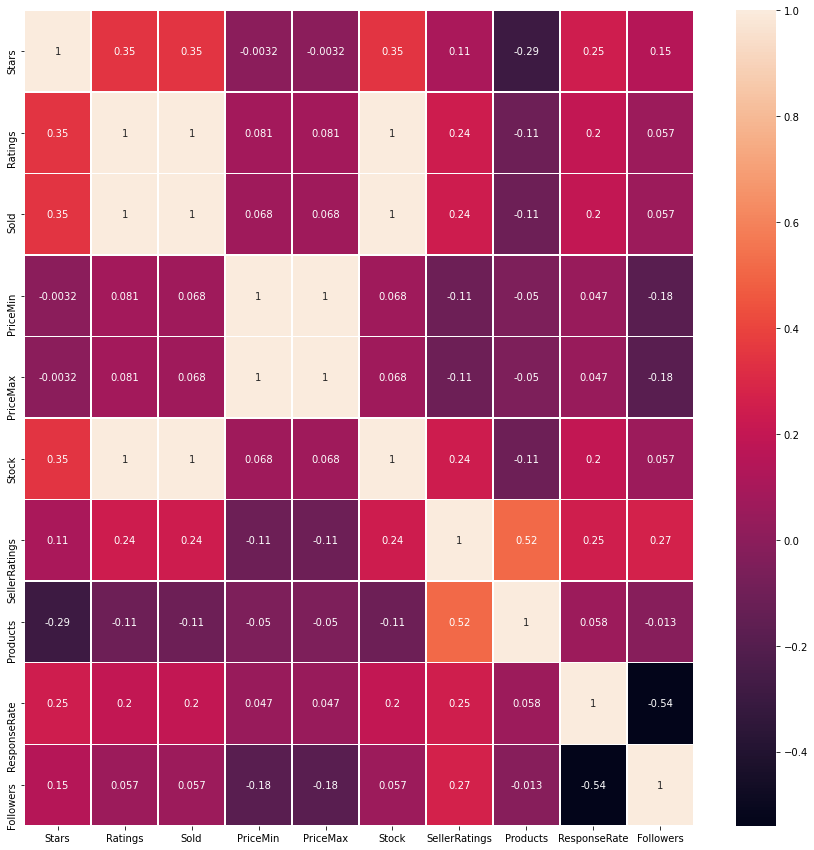

In [9]:
# Visualize the correlation using a heat map
plt.figure(figsize = (15,15))
sns.heatmap(df_corr, annot=True ,linewidths=.5)

plt.show()

8. Next, we plot the distribution and density of data for each variable. We can derive from these visual representation of the data, that a majority of sellers have *Followers* below the **250** range and a majority of the autmotive parts are being priced (*PriceMin/PriceMax*) below the **$75** range. This gives an indication of where the common pricing demand is and that most sellers have a small following. We can also see that most sellers also carry small quantities of *Stock* below the **250 unit** range.

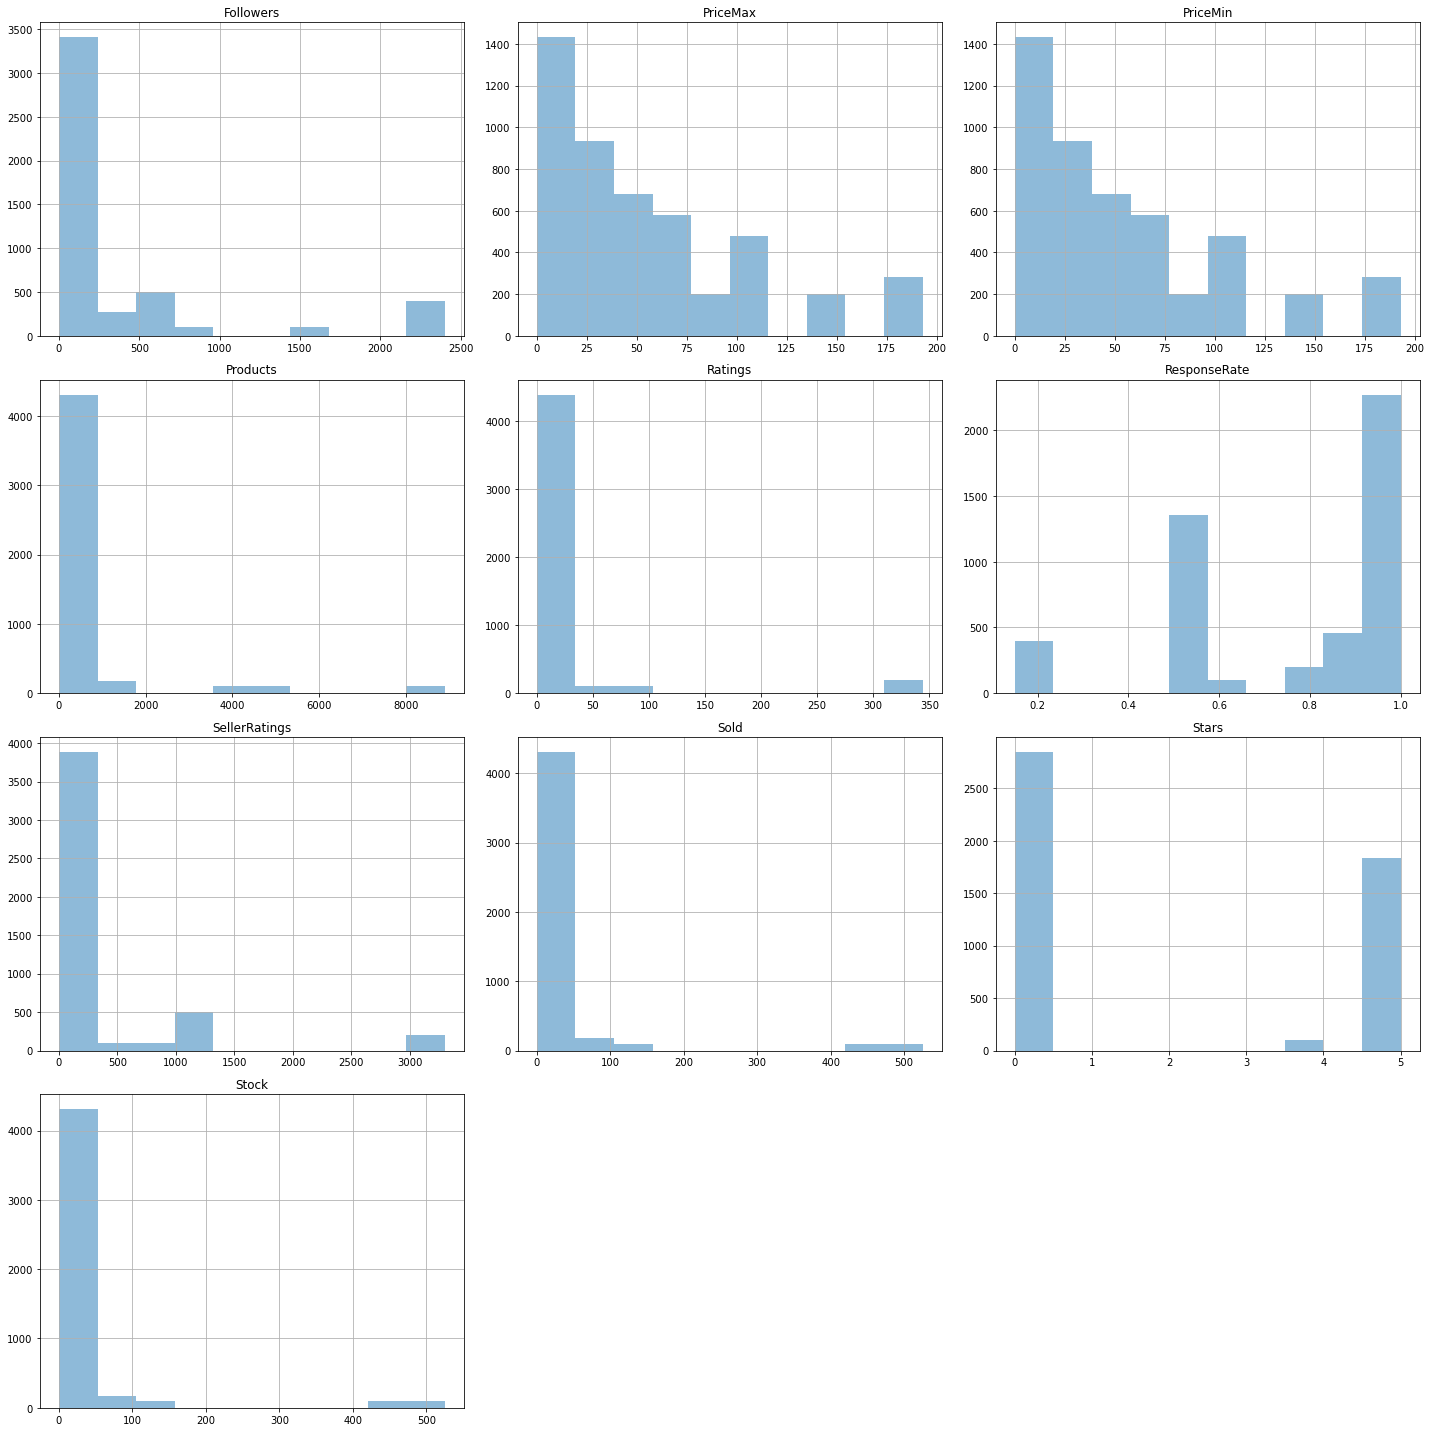

In [10]:
# Histogram plots of all variables
df.hist(alpha=0.5, figsize=(20, 20))

plt.tight_layout()
plt.show()

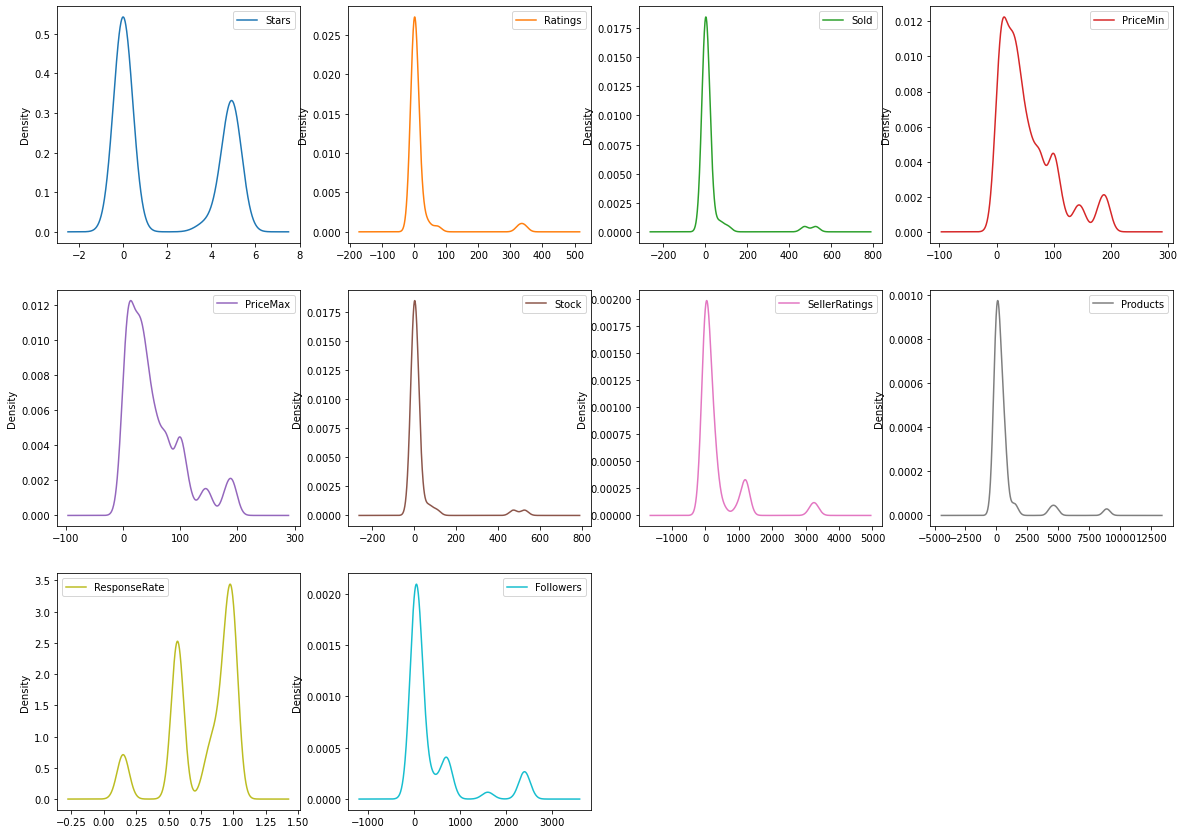

In [11]:
# Density plots of all variables
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False ,figsize=(20, 20))

plt.show()

9. Lastly, we perform box plots of the variables to see the outliers (extreme values) and concentration of the data. From these plots, we can glean the response rate of the sellers for example, with majority of sellers are closer to the median range. Possibly indicating that most sellers are responsive to their customers when messaged.

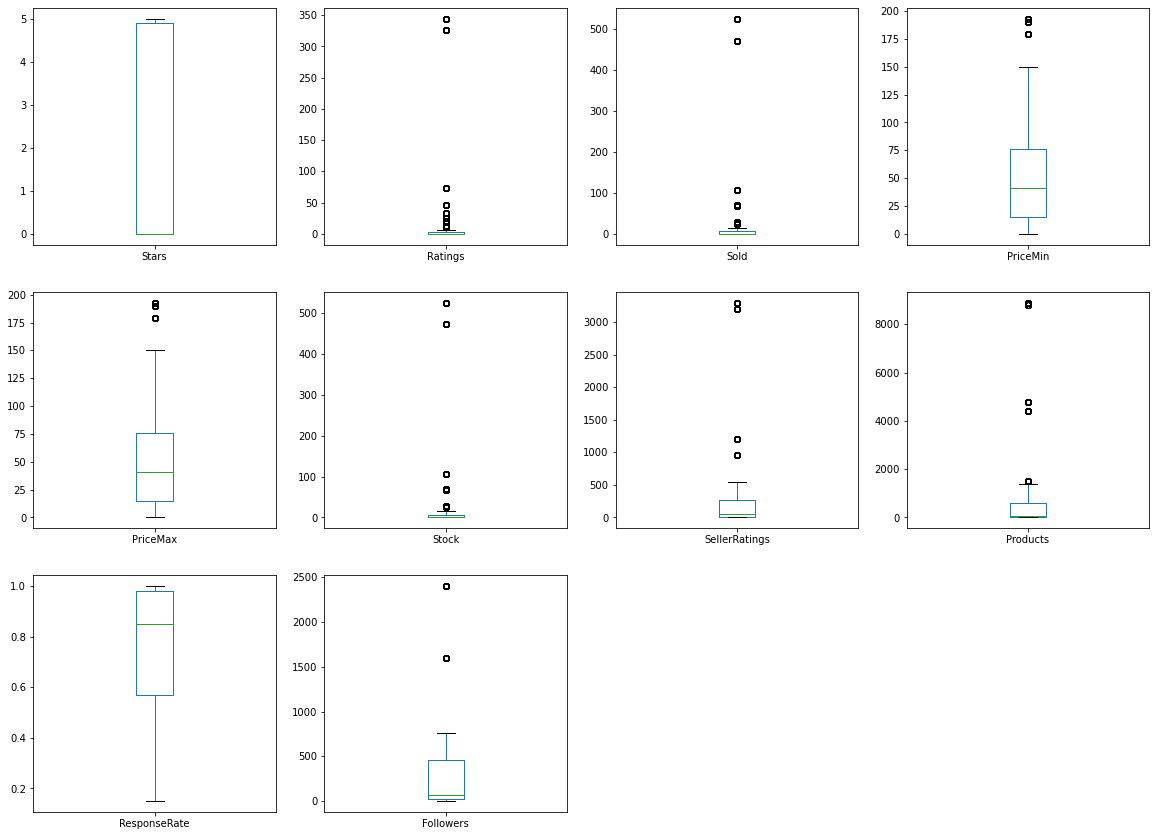

In [12]:
# Box plots of all variables
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False,figsize=(20, 20) )
plt.show()

10. For this section we will perform a random forest regression analysis. We will attempt to train and test the prediction of Followers based on the number of *Stars*, *Ratings* of each product, quantity of product *Sold*, available *Stock*, the number *SellerRatings* a seller receives from their customer, the number of *Products* the seller has and the *ResponseRate* percentage a seller has. We pick random forest, because it is a meta estimator that fits a number of classifying decision trees on sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [13]:
# Prepare the data for learning by removing variables with non-numerical values
df.drop(['Label'], axis=1, inplace=True)
df.drop(['Seller'], axis=1, inplace=True)
df.drop(['ResponseTime'], axis=1, inplace=True)
df.drop(['Joined'], axis=1, inplace=True)

In [14]:
# Perform normalization of the data
df_norm = pd.DataFrame(preprocessing.normalize(df))

In [15]:
# Get a data description of the normalized data set
df_norm.describe()

,0,1,2,3,4,5,6,7,8,9
count,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000,4785.000000
mean,0.004747,0.024656,0.039212,0.146357,0.146357,0.039212,0.316859,0.478944,0.003485,0.359465
std,0.007919,0.065276,0.097487,0.143260,0.143260,0.097487,0.344831,0.423267,0.005727,0.363412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003328,0.000062,0.000000
25%,0.000000,0.000000,0.000000,0.014285,0.014285,0.000000,0.000000,0.028502,0.000670,0.013533
50%,0.000000,0.000000,0.000000,0.088248,0.088248,0.000000,0.187079,0.378493,0.000955,0.190638
75%,0.003741,0.006193,0.017716,0.276551,0.276551,0.017716,0.606863,0.937991,0.003177,0.539540
max,0.031706,0.303851,0.449171,0.459775,0.459775,0.449171,0.952136,0.999972,0.024745,0.999994


In [16]:
# Break down the variables into X and Y, with Y being the expected outcome
X = df_norm.iloc[:, [0,1,2,3,4,5,6,7,8,]].values
y = df_norm.iloc[:,[9]].values

In [ ]:
# Divide the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df_norm, y, test_size = 0.2, random_state = 0)

In [ ]:
# Initialize the random forrest regressor for training
rnd_f = RandomForestRegressor(n_estimators = 200, random_state = 0)

# Fit the training data into the model for training
rnd_f.fit(X_train, y_train.ravel())

# We then perform the prediction using the test data
pred_y = rnd_f.predict(X_test)

# Print the prediction score or accuracy
print(metrics.r2_score(y_test,pred_y))

Due to the large data set, we were able to train and achieve a score of 100%.